# Data Preprocessing and Task Generation for Model Training

In this notebook, we will preprocess environmental datasets, generate tasks for model training, and perform sanity checks on the processed data. We will:
1. Load and preprocess temporal datasets such as **SST** and **Ice Concentration**.
2. Preprocess static datasets like **Lake Mask** and **Bathymetry**.
3. Use the **DeepSensor DataProcessor** to standardize and normalize the data.
4. Generate random coordinates from within the lake mask.
5. Create tasks using **TaskLoader** for model training.

Let's start by importing the necessary packages and defining helper functions.


## Step 1: Import Packages and Define Helper Functions

Here, we import the libraries that are needed for data manipulation, visualization, and training the model. Key libraries include:
- `xarray`: For handling multi-dimensional datasets (e.g., NetCDF, Zarr).
- `cartopy`: For geographic visualizations.
- `dask`: For efficient handling of large arrays.
- `deepsensor`: For the model and data processing pipeline.
- `torch`: For working with PyTorch models.

We also define the `standardize_dates` function, which ensures that the time dimension in the dataset is converted to a date-only format (`datetime64[D]`), removing the time component. The `generate_random_coordinates` function is used to select N random points from within a masked area (e.g., the lakes). 


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask.array as da
import gcsfs
import os

import deepsensor.torch
from deepsensor.data import DataProcessor, TaskLoader, construct_circ_time_ds
from deepsensor.data.sources import get_era5_reanalysis_data, get_earthenv_auxiliary_data, \
    get_gldas_land_mask
from deepsensor.model import ConvNP
from deepsensor.train import set_gpu_default_device

from deepsensor_greatlakes.utils import standardize_dates, generate_random_coordinates
from deepsensor_greatlakes.preprocessor import SeasonalCycleProcessor, list_saved_seasonal_cycles

## Step 2: Data Inventory and Preprocessing

In this section, we load several Great Lakes datasets that we will use for model training:
- **Ice Concentration**: This dataset contains information about the ice cover in the Great Lakes.
- **GLSEA (Sea Surface Temperature)**: This dataset represents sea surface temperature over time, as derived from satellite products.
- **Bathymetry**: A dataset of the depth of the Great Lakes.
- **Lake Mask**: A binary mask that indicates the presence of water in each grid cell.

We'll load these datasets from the U-M HPC storage or Google Cloud Platform and apply preprocessing steps to handle missing values, convert times to a standardized date format, and drop unnecessary variables.


In [4]:
# Path to the Zarr stores (NOTE: This won't work on U-M HPC. Paths must be changed)
#bathymetry_path = 'gs://great-lakes-osd/context/interpolated_bathymetry.nc'
#mask_path = 'gs://great-lakes-osd/context/lakemask.nc'
#ice_concentration_path = 'gs://great-lakes-osd/ice_concentration.zarr'
#glsea_path = 'gs://great-lakes-osd/GLSEA_combined.zarr'
#glsea3_path = 'gs://great-lakes-osd/GLSEA3_combined.zarr'

# Path to the files on U-M HPC
bathymetry_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/bathymetry/interpolated_bathymetry.nc'
mask_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/masks/lakemask.nc'
ice_concentration_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/NSIDC/ice_concentration.zarr'
glsea_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/GLSEA_combined.zarr'
glsea3_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/GLSEA3_combined.zarr'

## Step 3: Load Temporal Datasets (SST, Ice Concentration)

In this section, we load the **SST** and **Ice Concentration** datasets. These datasets are stored in the Zarr format, which is efficient for large-scale datasets. We open these datasets and apply the following preprocessing:
- **Replace invalid land values (-1) with `NaN`** to ensure that the land areas do not interfere with our analysis.
- **Standardize the time dimension** by converting it to a date-only format.

Let’s load and preprocess the data now.


In [5]:
# Open the Zarr stores
ice_concentration_raw = xr.open_zarr(ice_concentration_path, chunks={'time': 366, 'lat': 200, 'lon': 200})
glsea_raw = xr.open_zarr(glsea_path, chunks={'time': 366, 'lat': 200, 'lon': 200})
glsea3_raw = xr.open_zarr(glsea3_path, chunks={'time': 366, 'lat': 200, 'lon': 200})

# Replace -1 (land value) with NaN
ice_concentration_raw = ice_concentration_raw.where(ice_concentration_raw != -1, float('nan'))

# Convert all times to date-only format, removing the time component
ice_concentration_raw = standardize_dates(ice_concentration_raw)
glsea_raw = standardize_dates(glsea_raw)
glsea3_raw = standardize_dates(glsea3_raw)

# Drop CRS - not needed
glsea_raw = glsea_raw.drop_vars('crs')
glsea3_raw = glsea3_raw.drop_vars('crs')

## Step 4: Load Static Datasets (Lake Mask and Bathymetry)

In this section, we load two static datasets:
- **Bathymetry**: The depth of the Great Lakes, which is useful for understanding the physical characteristics of the lakes. DeepSensor can use this to infer aspects of the covariance.
- **Lake Mask**: A binary mask indicating the presence of water in each grid cell.

These datasets are opened from NetCDF files and processed similarly to the temporal datasets.


In [6]:
# Open the NetCDF files using xarray 
bathymetry_raw = xr.open_dataset(bathymetry_path)
lakemask_raw = xr.open_dataset(mask_path)

# Name the bathymetry variable (only needed if reading from GCP)
#bathymetry_raw = bathymetry_raw.rename({'__xarray_dataarray_variable__': 'bathymetry'})

## Step 5: Initialize the Data Processor

The **DataProcessor** class from DeepSensor is used to preprocess and normalize the datasets. It applies operations like scaling and handling missing values, ensuring that the data is ready for training. Here, we initialize the DataProcessor with the appropriate spatial dimensions (`lat` and `lon`).

Once the DataProcessor is initialized, we apply it to the datasets to perform the necessary transformations and normalizations.


In [7]:
data_processor = DataProcessor(x1_name="lat", x2_name="lon")
print(data_processor)

DataProcessor with normalisation params:
{'coords': {'time': {'name': 'time'},
            'x1': {'map': None, 'name': 'lat'},
            'x2': {'map': None, 'name': 'lon'}}}


In [8]:
#glsea = data_processor(glsea_raw)
_ = data_processor(glsea_raw.sel(time=slice("2009-01-01", "2009-12-31")))
glsea = data_processor(glsea_raw)

# process the bathymetry and lake
bathymetry, lakemask = data_processor([bathymetry_raw, lakemask_raw], method="min_max")

In [9]:
# Select a subset of the ice concentration data to compute normalization parameters
#_ = data_processor(ice_concentration_raw.sel(time=slice("2009-01-01", "2009-01-31")))

# Now apply the normalization parameters to the full ice concentration dataset
#ice_concentration = data_processor(ice_concentration_raw, method="min_max")


In [10]:
data_processor.config

{'coords': {'time': {'name': 'time'},
  'x1': {'name': 'lat', 'map': (38.8749871947229, 55.4132976408956)},
  'x2': {'name': 'lon', 'map': (-92.4199507342304, -75.8816402880577)}},
 'sst': {'method': 'mean_std',
  'params': {'mean': 7.873531818389893, 'std': 6.944828510284424}},
 'bathymetry': {'method': 'min_max',
  'params': {'min': 9.999999999999998, 'max': 316.62872313037894}},
 'mask': {'method': 'min_max', 'params': {'min': 0.0, 'max': 1.0}}}

In [11]:
dates = pd.date_range(glsea.time.values.min(), glsea.time.values.max(), freq="D")

In [12]:
doy_ds = construct_circ_time_ds(dates, freq="D")
cosD = standardize_dates(doy_ds["cos_D"])
sinD = standardize_dates(doy_ds["sin_D"])

## Step 6: Sanity Check for GLSEA Data

Before we proceed further, we perform a quick sanity check on the **GLSEA** dataset by visualizing a single time slice. This helps us confirm that the dataset is being processed correctly and that we can visualize the sea surface temperature (SST) values over time.

We plot the GLSEA data for a selected time point, ensuring everything is aligned and displayed as expected.


In [13]:
glsea

<xarray.Dataset> Size: 40GB
Dimensions:  (time: 10221, x1: 838, x2: 1181)
Coordinates:
  * time     (time) datetime64[s] 82kB 1995-01-01 1995-01-02 ... 2022-12-31
  * x1       (x1) float64 7kB 0.0 0.0008475 0.001695 ... 0.7076 0.7085 0.7093
  * x2       (x2) float64 9kB 0.0 0.0008475 0.001695 ... 0.9983 0.9992 1.0
Data variables:
    sst      (time, x1, x2) float32 40GB dask.array<chunksize=(366, 200, 200), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.5
    GDAL:         GDAL 2.1.3, released 2017/20/01
    history:      Tue Feb 13 20:15:43 2024: cdo selyear,1995 GLSEA_SST_1995_2...
    source:       1995_001_glsea.asc
    title:        SST from Great Lakes Surface Environmental Analysis (GLSEA)

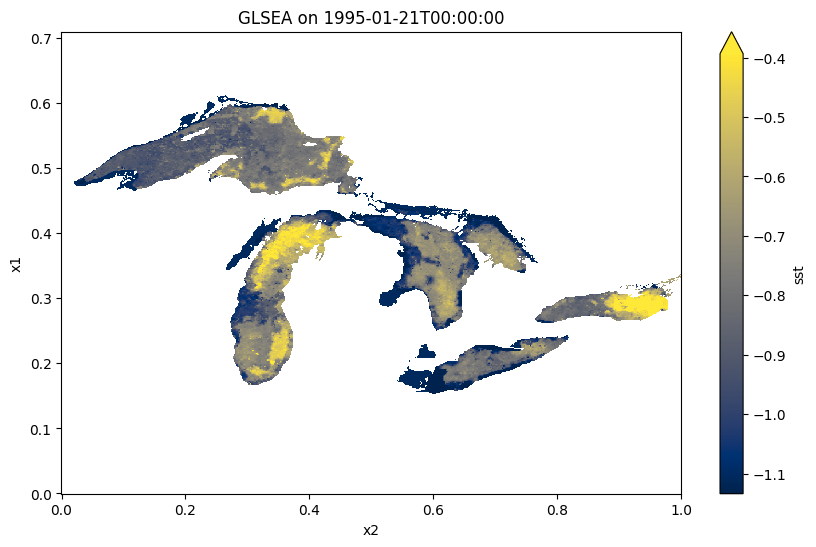

In [14]:
# Load the dataset
ds = glsea

# Select a single time slice to plot, e.g., the first time point
time_index = 20
time_slice = ds.isel(time=time_index)

# Plotting
plt.figure(figsize=(10, 6))
ice_conc_plot = time_slice.sst.plot(
    x='x2', 
    y='x1', 
    cmap='cividis',
    robust=True  # Automatically exclude extreme outliers from color scaling
)
plt.title(f"GLSEA on {str(time_slice.time.values)}")
plt.show()

## Step 7: Sanity Check for Bathymetry Data

We now perform a sanity check for the **Bathymetry** dataset by plotting the data to check that it is properly loaded and visualized. The bathymetry data shows the underwater topography of the Great Lakes, which DeepSensor can use as an additional context dataset. 

We visualize the bathymetry data to check for consistency.


In [15]:
bathymetry

<xarray.Dataset> Size: 696kB
Dimensions:     (x1: 240, x2: 360)
Coordinates:
  * x1          (x1) float64 2kB 0.1523 0.1542 0.1561 ... 0.5958 0.5976 0.5995
  * x2          (x2) float64 3kB 0.02107 0.02375 0.02642 ... 0.9791 0.9818
Data variables:
    bathymetry  (x1, x2) float64 691kB nan nan nan nan nan ... nan nan nan nan

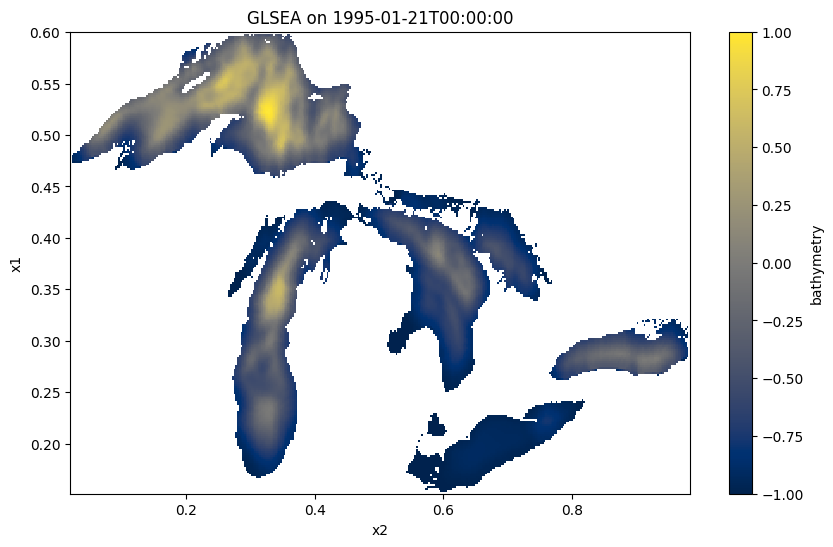

In [16]:
# Load the dataset
ds = bathymetry

# Plotting
plt.figure(figsize=(10, 6))
ice_conc_plot = ds.bathymetry.plot(
    x='x2', 
    y='x1', 
    cmap='cividis',
    robust=True  # Automatically exclude extreme outliers from color scaling
)
plt.title(f"GLSEA on {str(time_slice.time.values)}")
plt.show()

## Step 8: Sanity Check for Lake Mask

Finally, we perform a sanity check for the **Lake Mask** dataset. The lake mask should be a binary mask where `1` represents water and `0` represents land. We plot the mask to confirm that it accurately reflects the boundaries of the lakes.

This step helps us check that the mask is correctly aligned with the spatial extent of the other datasets.


In [17]:
lakemask

<xarray.Dataset> Size: 4MB
Dimensions:  (x1: 838, x2: 1181)
Coordinates:
  * x1       (x1) float64 7kB 0.0 0.0008475 0.001695 ... 0.7076 0.7085 0.7093
  * x2       (x2) float64 9kB 0.0 0.0008475 0.001695 ... 0.9983 0.9992 1.0
Data variables:
    mask     (x1, x2) float32 4MB -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0

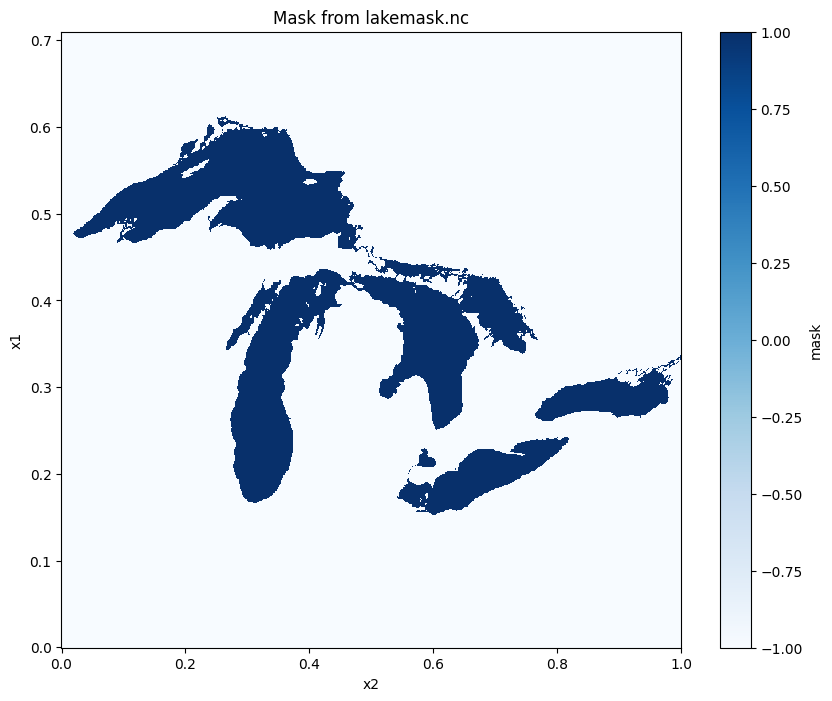

In [18]:
# Plot lakemask
lakemask_mask = lakemask['mask']

# Plot the data
plt.figure(figsize=(10, 8))
lakemask_mask.plot(cmap='Blues', add_colorbar=True)
plt.title('Mask from lakemask.nc')
plt.show()

## Step 9: Save the Data Processor Configuration

After preprocessing the data, we save the **DataProcessor** configuration to disk. This allows us to reuse the same preprocessing steps later, ensuring consistency between training runs.

We save the configuration to a specified directory (`../deepsensor_config/`), which can later be loaded for training or inference.


In [19]:
data_processor.save("../deepsensor_config/")

## Step 10: Generate Random Coordinates within the Lake Mask

In this section, we generate random coordinates within the **lake mask**. These coordinates are used to sample points inside the Great Lakes region. The **DataProcessor** will normalize these coordinates, getting them ready for use in model training.

We generate a set of random points and plot them to verify that they are distributed correctly within the lake area.


In [20]:
# Example usage
N = 100  # Number of random points
random_lake_points = generate_random_coordinates(lakemask_raw, N, data_processor)

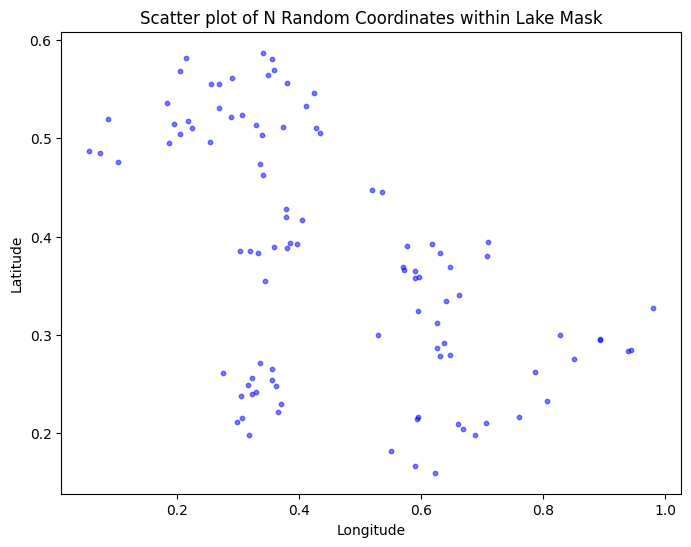

In [21]:
import matplotlib.pyplot as plt

# Assuming random_coords is the (2, N) array from the previous step
latitudes = random_lake_points[0, :]
longitudes = random_lake_points[1, :]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(longitudes, latitudes, color='blue', alpha=0.5, s=10)
plt.title("Scatter plot of N Random Coordinates within Lake Mask")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


## Step 11: Task Generation for Model Training (Example)

In this section, we generate tasks for training the model. Tasks are the individual units of data that the model will learn from, containing context (input data) and target (output data). Note that this is only a single sample - more detailed training will be covered in the next notebook. 

We use the **TaskLoader** to sample from the datasets. A task consists of:
1. **Context**: Data from **GLSEA**, **Bathymetry**, and **Lake Mask**.
2. **Target**: The dataset that the model will predict, such as **SST** or **Ice Concentration**.

We generate training tasks and visualizations of a sample task to ensure everything is in order before we begin model training.


In [22]:
from deepsensor.data import TaskLoader
task_loader = TaskLoader(context=[glsea, bathymetry, lakemask], target=glsea)

In [23]:
task_loader.context

(<xarray.Dataset> Size: 40GB
 Dimensions:  (time: 10221, x1: 838, x2: 1181)
 Coordinates:
   * time     (time) datetime64[s] 82kB 1995-01-01 1995-01-02 ... 2022-12-31
   * x1       (x1) float32 3kB 0.0 0.0008475 0.001695 ... 0.7076 0.7085 0.7093
   * x2       (x2) float32 5kB 0.0 0.0008475 0.001695 ... 0.9983 0.9992 1.0
 Data variables:
     sst      (time, x1, x2) float32 40GB dask.array<chunksize=(366, 200, 200), meta=np.ndarray>
 Attributes:
     CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
     CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...
     Conventions:  CF-1.5
     GDAL:         GDAL 2.1.3, released 2017/20/01
     history:      Tue Feb 13 20:15:43 2024: cdo selyear,1995 GLSEA_SST_1995_2...
     source:       1995_001_glsea.asc
     title:        SST from Great Lakes Surface Environmental Analysis (GLSEA),
 <xarray.Dataset> Size: 348kB
 Dimensions:     (x1: 240, x2: 360)
 Coordinates:
   * x1          (x1) float32 

In [24]:
task = task_loader("2011-08-16T00:00:00", context_sampling=random_lake_points, target_sampling="all")

In [25]:
task

time: Timestamp/2011-08-16 00:00:00
ops: []
X_c: ['ndarray/float32/(2, 100)', 'ndarray/float32/(2, 100)', 'ndarray/float32/(2, 100)']
Y_c: ['ndarray/float32/(1, 100)', 'ndarray/float32/(1, 100)', 'ndarray/float32/(1, 100)']
X_t: [('ndarray/float32/(1, 838)', 'ndarray/float32/(1, 1181)')]
Y_t: ['ndarray/float32/(1, 838, 1181)']

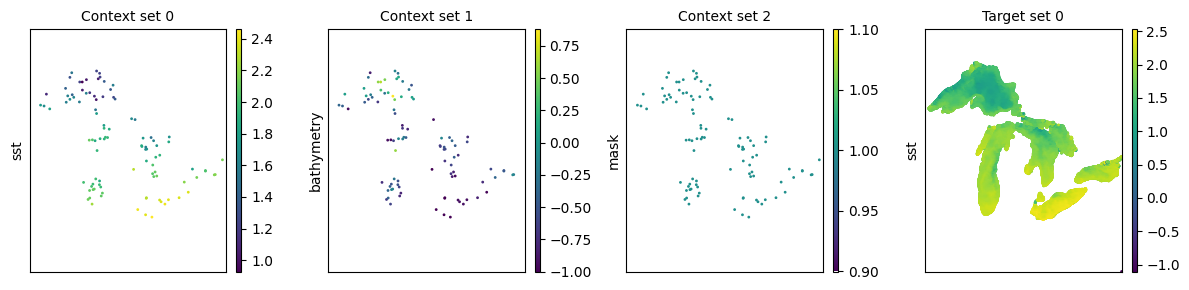

In [26]:
fig = deepsensor.plot.task(task, task_loader)
plt.show()

In the above task, we are asking DeepSensor to learn the relationship between the inputs (SST, bathymetry) sampled at 100 random points within the lakes and the SST across all of the lakes. This mapping task essentially gives us a way to estimate the entire lake surface temperature from a set of observations, which we could then check against other estimates of lakewide SST. 

# Conclusion

In this notebook, we successfully preprocessed several Great Lakes datasets for training a model. We:
1. Loaded and standardized the **SST**, **Ice Concentration**, **Bathymetry**, and **Lake Mask** datasets.
2. Generated random coordinates for sampling inside the Great Lakes region.
3. Created tasks using the **TaskLoader**, which will be used during model training.

The next steps involve using these preprocessed tasks to train a model and evaluate its performance. Feel free to refer to the saved DataProcessor configuration in future notebooks for consistency in data preprocessing.
